<a href="https://colab.research.google.com/github/ymkge/competiton/blob/main/tutorial_nishika_25_mansion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 不動産価格予測 2022冬の部

## googleドライブへのマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
# googleドライブの作業用ディレクトリを設定
YOUR_PATH = "/content/drive/MyDrive/xxxxxxxx"

In [24]:
cd {YOUR_PATH}

/content/drive/MyDrive/Notebooks/competition/used_condominium


## 必要なライブラリのインストール(xfeatと日本語版matplotlib)

In [17]:
!pip install optuna xfeat japanize-matplotlib >> /dev/null

## 必要なライブラリの読み出し

In [18]:
import re

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
sns.set(font="IPAexGothic")

from glob import glob
from functools import partial
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from xfeat import SelectCategorical, LabelEncoder, LambdaEncoder, Pipeline, ConcatCombination, SelectNumerical, \
    ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer

## モデル入力用データの整形処理の準備

In [19]:
def normalize_moyori(moyori):
    if moyori == moyori:
        if moyori == '30分?60分':
            moyori = 45
        elif moyori == '1H?1H30':
            moyori = 75
        elif moyori == '1H30?2H':
            moyori = 105
        elif moyori == '2H?':
            moyori = 120
        moyori = int(float(moyori))
    return moyori

In [20]:
def normalize_area(area):
    if area == area:
        area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
    return area

In [21]:
def convert_wareki_to_seireki(wareki):
    if wareki == wareki:
        if wareki == '戦前':
            wareki = '昭和20年'
        value = wareki[2:-1]
        if value == '元':
            value = 1
        else:
            value = int(value)
        if '昭和' in wareki:
            seireki = 1925+value
        elif '平成' in wareki:
            seireki = 1988+value
        elif '令和' in wareki:
            seireki = 2018+value
    else:
        seireki = wareki
    return seireki

In [25]:
!ls

data


## コンペ用データをgoogleドライブへ以下のように設定する

コンペデータ作成（利用カラム、目的変数など決める）

dataディレクトリ配下に以下のようにデータを格納しているとする

├─ input<br>
│   ├─ data_explanation.xlsx<br>
│   ├─ sample_submission.csv<br>
│   ├─ test.csv<br>
│   └─ train<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ 01.csv<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ 02.csv<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ 03.csv<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─ ...<br>
│       &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└─ 47.csv<br>
└─ output


In [26]:
BASE_PATH = './data/'

## 学習用データの取り込み

In [27]:
paths = glob(BASE_PATH + 'input/train/*')
train_dfs = []
for path in paths:
    train_df = pd.read_csv(path)
    train_dfs.append(train_df)
train_df = pd.concat(train_dfs)
train_df.reset_index(drop=True, inplace=True)
test_df = pd.read_csv(BASE_PATH + 'input/test.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [57]:
train_df.head()

,ID,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_enc,都道府県名_te,取引時点_何年前,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,改装,取引の事情等,面積（㎡）容積率（％）_combi,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_count_面積（㎡）_grpby_市区町村名,agg_count_建ぺい率（％）_grpby_市区町村名,agg_count_容積率（％）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_mean_面積（㎡）_grpby_市区町村名,agg_mean_建ぺい率（％）_grpby_市区町村名,agg_mean_容積率（％）_grpby_市区町村名,agg_min_最寄駅：距離（分）_grpby_市区町村名,agg_min_面積（㎡）_grpby_市区町村名,agg_min_建ぺい率（％）_grpby_市区町村名,agg_min_容積率（％）_grpby_市区町村名,agg_max_最寄駅：距離（分）_grpby_市区町村名,agg_max_面積（㎡）_grpby_市区町村名,agg_max_建ぺい率（％）_grpby_市区町村名,agg_max_容積率（％）_grpby_市区町村名
0,23197559,NaN,65,1990.0,60.0,200.0,7.113943,0,0.0,16,0,0,0,0,0,0,0,-1,0,0,-1,130.0,1007,1069,1068,1068,11.051639,72.427502,66.292135,263.623596,1.0,20,60.0,150.0,45.0,165,80.0,600.0
1,13338234,3.0,20,2005.0,60.0,200.0,7.322219,0,0.0,16,1,1,1,1,1,0,0,-1,1,1,-1,40.0,7705,7946,7895,7895,7.127190,40.997357,69.022166,283.806206,0.0,10,30.0,60.0,120.0,470,80.0,600.0
2,14195846,NaN,85,1992.0,NaN,NaN,7.556303,0,0.0,16,2,2,2,2,2,1,0,-1,-1,0,-1,NaN,4725,5013,4702,4702,7.624974,45.796928,75.257337,463.717567,0.0,10,40.0,60.0,45.0,960,80.0,1200.0
3,14254201,6.0,45,NaN,NaN,NaN,6.863323,0,0.0,16,2,3,3,3,3,2,0,-1,-1,1,-1,NaN,2103,2159,2018,2018,23.269615,61.350162,59.405352,168.830525,0.0,15,40.0,80.0,120.0,1000,80.0,500.0
4,14279983,4.0,50,1974.0,NaN,NaN,7.079181,0,0.0,16,2,4,4,4,4,0,0,-1,-1,0,-1,NaN,3542,3752,3448,3448,13.905138,67.306770,59.477958,170.887471,0.0,15,30.0,60.0,120.0,210,80.0,500.0


In [58]:
test_df.head()

,ID,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_enc,都道府県名_te,取引時点_何年前,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,改装,取引の事情等,面積（㎡）容積率（％）_combi,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_count_面積（㎡）_grpby_市区町村名,agg_count_建ぺい率（％）_grpby_市区町村名,agg_count_容積率（％）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_mean_面積（㎡）_grpby_市区町村名,agg_mean_建ぺい率（％）_grpby_市区町村名,agg_mean_容積率（％）_grpby_市区町村名,agg_min_最寄駅：距離（分）_grpby_市区町村名,agg_min_面積（㎡）_grpby_市区町村名,agg_min_建ぺい率（％）_grpby_市区町村名,agg_min_容積率（％）_grpby_市区町村名,agg_max_最寄駅：距離（分）_grpby_市区町村名,agg_max_面積（㎡）_grpby_市区町村名,agg_max_建ぺい率（％）_grpby_市区町村名,agg_max_容積率（％）_grpby_市区町村名
692882,14066782,9.0,70,2006.0,60.0,200.0,7.499662,62,7.269257,0,2,59,843,869,0,0,0,0,5,1,-1,140.0,1856,1970,1758,1758,10.186961,58.42132,60.011377,193.498294,1.0,10,40.0,80.0,45.0,480,80.0,500.0
692883,14068138,3.0,65,1983.0,60.0,200.0,7.339282,62,7.269257,0,2,59,213,253,0,0,0,0,0,1,-1,130.0,1856,1970,1758,1758,10.186961,58.42132,60.011377,193.498294,1.0,10,40.0,80.0,45.0,480,80.0,500.0
692884,14066817,14.0,70,1987.0,60.0,200.0,7.388534,62,7.269257,0,2,59,843,124,0,0,0,0,8,0,-1,140.0,1856,1970,1758,1758,10.186961,58.42132,60.011377,193.498294,1.0,10,40.0,80.0,45.0,480,80.0,500.0
692885,14067326,12.0,65,1986.0,60.0,200.0,7.350723,62,7.269257,0,2,59,1982,763,0,0,0,0,0,0,-1,130.0,1856,1970,1758,1758,10.186961,58.42132,60.011377,193.498294,1.0,10,40.0,80.0,45.0,480,80.0,500.0
692886,14067555,7.0,20,1987.0,60.0,200.0,6.742733,62,7.269257,0,2,59,178,161,-1,0,0,0,8,1,-1,40.0,1856,1970,1758,1758,10.186961,58.42132,60.011377,193.498294,1.0,10,40.0,80.0,45.0,480,80.0,500.0


## NULLのある項目を確認

In [28]:
train_df.isnull().sum()

ID                   0
種類                   0
地域              692882
市区町村コード              0
都道府県名                0
市区町村名                0
地区名                661
最寄駅：名称            2695
最寄駅：距離（分）        23121
間取り              24432
面積（㎡）                0
土地の形状           692882
間口              692882
延床面積（㎡）         692882
建築年              20074
建物の構造            17386
用途               62613
今後の利用目的         364738
前面道路：方位         692882
前面道路：種類         692882
前面道路：幅員（ｍ）      692882
都市計画             19425
建ぺい率（％）          23625
容積率（％）           23625
取引時点                 0
改装               64026
取引の事情等          674203
取引価格（総額）_log         0
dtype: int64

In [29]:
sub_df = pd.read_csv(BASE_PATH + 'input/sample_submission.csv')

In [59]:
sub_df

,ID,取引価格（総額）_log
0,1000001,7.067838
1,1000002,7.320210
2,1000066,7.460405
3,1000119,6.931960
4,1000120,6.933208
...,...,...
22390,47006237,7.495266
22391,47006258,7.443273
22392,47006316,7.363863
22393,47006474,7.376567


In [30]:
ID = 'ID'
TARGET = '取引価格（総額）_log'
rm_cols = []

## 削除用項目を選定してtrainとtestデータから削除する

In [31]:
df = pd.concat([train_df, test_df])

rm_cols += ['市区町村コード']
for i,v in df.nunique().iteritems():
    if v <= 1:
        rm_cols.append(i)

rm_cols

['市区町村コード',
 '種類',
 '地域',
 '土地の形状',
 '間口',
 '延床面積（㎡）',
 '前面道路：方位',
 '前面道路：種類',
 '前面道路：幅員（ｍ）']

In [32]:
test_df[TARGET] = np.nan
train_df.drop(rm_cols, axis=1, inplace=True)
test_df.drop(rm_cols, axis=1, inplace=True)
df = pd.concat([train_df, test_df])
df.sort_values('取引時点', inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(715277, 19)

In [33]:
df['取引時点'].unique()

array(['2005年第3四半期', '2005年第4四半期', '2006年第1四半期', '2006年第2四半期',
       '2006年第3四半期', '2006年第4四半期', '2007年第1四半期', '2007年第2四半期',
       '2007年第3四半期', '2007年第4四半期', '2008年第1四半期', '2008年第2四半期',
       '2008年第3四半期', '2008年第4四半期', '2009年第1四半期', '2009年第2四半期',
       '2009年第3四半期', '2009年第4四半期', '2010年第1四半期', '2010年第2四半期',
       '2010年第3四半期', '2010年第4四半期', '2011年第1四半期', '2011年第2四半期',
       '2011年第3四半期', '2011年第4四半期', '2012年第1四半期', '2012年第2四半期',
       '2012年第3四半期', '2012年第4四半期', '2013年第1四半期', '2013年第2四半期',
       '2013年第3四半期', '2013年第4四半期', '2014年第1四半期', '2014年第2四半期',
       '2014年第3四半期', '2014年第4四半期', '2015年第1四半期', '2015年第2四半期',
       '2015年第3四半期', '2015年第4四半期', '2016年第1四半期', '2016年第2四半期',
       '2016年第3四半期', '2016年第4四半期', '2017年第1四半期', '2017年第2四半期',
       '2017年第3四半期', '2017年第4四半期', '2018年第1四半期', '2018年第2四半期',
       '2018年第3四半期', '2018年第4四半期', '2019年第1四半期', '2019年第2四半期',
       '2019年第3四半期', '2019年第4四半期', '2020年第1四半期', '2020年第2四半期',
       '2020年第3四半期', '2020年第4四半期', '2021年第1四半期', '2021年

In [34]:
val_min_idx = min(df[df['取引時点'].str.contains('2020年第3四半期|2020年第4四半期', regex=True)].index)
test_min_idx = min(df[df['取引時点'].str.contains('2021年第1四半期|2021年第2四半期', regex=True)].index)
val_min_idx, test_min_idx

(663186, 692882)

In [35]:
set(df.iloc[val_min_idx:test_min_idx, :]['取引時点'].values)

{'2020年第3四半期', '2020年第4四半期'}

## 特徴量生成

In [36]:
enc_dic = {}
for i, e in enumerate(sorted(list(set(df['取引時点'].values)))):
    enc_dic[e] = i
df['取引時点_enc'] = df['取引時点'].map(enc_dic)

In [37]:
te_dic = {}
time_col = '取引時点_enc'
group_col = '都道府県名'

for i in set(df[time_col].values):
    tmp_df = df[df[time_col] < i]
    te_dic[i] = tmp_df.groupby(group_col)[TARGET].agg('mean').to_dict()

te_dic[50]

{'三重県': 7.099989772836439,
 '京都府': 7.155935848555253,
 '佐賀県': 7.009937258263509,
 '兵庫県': 7.157742870483196,
 '北海道': 6.965967793677859,
 '千葉県': 7.155825324964995,
 '和歌山県': 7.022690210815773,
 '埼玉県': 7.1697442713966355,
 '大分県': 6.911537826573079,
 '大阪府': 7.158352973821201,
 '奈良県': 7.056884610234688,
 '宮城県': 7.0395442538048805,
 '宮崎県': 6.958678653711235,
 '富山県': 7.0469200713870155,
 '山口県': 7.045342730349803,
 '山形県': 7.087990602814902,
 '山梨県': 6.848839888686708,
 '岐阜県': 7.078095913486453,
 '岡山県': 7.03809073492747,
 '岩手県': 6.925002679060599,
 '島根県': 7.165376214700312,
 '広島県': 7.093449021655064,
 '徳島県': 6.912051981629745,
 '愛媛県': 6.966433011596662,
 '愛知県': 7.107301969238601,
 '新潟県': 6.913835156235044,
 '東京都': 7.377929204641064,
 '栃木県': 6.950636958071011,
 '沖縄県': 7.160046604428336,
 '滋賀県': 7.16602695816839,
 '熊本県': 6.970182251843263,
 '石川県': 6.929363348877185,
 '神奈川県': 7.2581182672098175,
 '福井県': 6.979575815840195,
 '福岡県': 6.992264905042226,
 '福島県': 6.9743805791401785,
 '秋田県': 6.9413137471126

In [38]:
def calc_te(row):
    if row[time_col] in te_dic and row[group_col] in te_dic[row[time_col]]:
        return te_dic[row[time_col]][row[group_col]]
    else:
        return 0

df[group_col+'_te'] = df.apply(calc_te, axis=1)
df.head(2)

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,取引時点_enc,都道府県名_te
0,23197559,愛知県,名古屋市北区,鳩岡,黒川(愛知),NaN,３ＬＤＫ,65,平成2年,ＲＣ,住宅,NaN,第１種住居地域,60.0,200.0,2005年第3四半期,改装済,NaN,7.113943,0,0.0
1,13338234,東京都,杉並区,和田,中野富士見町,3,１Ｋ,20,平成17年,ＲＣ,住宅,NaN,準工業地域,60.0,200.0,2005年第3四半期,未改装,NaN,7.322219,0,0.0


In [39]:
df['取引時点_何年前'] = df['取引時点'].apply(lambda x: 2021-int(x[:4]))
df.drop(['取引時点'], axis=1, inplace=True)
df['建築年'] = df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))
df['面積（㎡）'] = df['面積（㎡）'].apply(lambda x: normalize_area(x))
df['最寄駅：距離（分）'] = df['最寄駅：距離（分）'].apply(lambda x: normalize_moyori(x))

In [40]:
num_df = SelectNumerical().fit_transform(df)
num_df.head(2)

,ID,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_enc,都道府県名_te,取引時点_何年前
0,23197559,NaN,65,1990.0,60.0,200.0,7.113943,0,0.0,16
1,13338234,3.0,20,2005.0,60.0,200.0,7.322219,0,0.0,16


In [41]:
encoder = Pipeline([
    SelectCategorical(),
    LabelEncoder(output_suffix=""),
])

le_df = encoder.fit_transform(df)
le_df.head(2)

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,改装,取引の事情等
0,0,0,0,0,0,0,0,-1,0,0,-1
1,1,1,1,1,1,0,0,-1,1,1,-1


In [42]:
encoder = Pipeline(
    [
        SelectNumerical(),
        ArithmeticCombinations(
            input_cols=["面積（㎡）", "容積率（％）"], 
            drop_origin=True, 
            operator="*", 
            r=2,
        ),
    ]
)

num_comb_df = encoder.fit_transform(df)/100
num_comb_df.head(2)

,面積（㎡）容積率（％）_combi
0,130.0
1,40.0


In [43]:
agg_dfs = []

def get_agg_df(df, group_col):

    agg_df, agg_cols = aggregation(df,
                        group_key=group_col,
                        group_values=['最寄駅：距離（分）', '面積（㎡）', '建ぺい率（％）', '容積率（％）'],
                        agg_methods=['count', 'mean', 'min', 'max'],
                        )

    return agg_df[agg_cols]

group_col = '市区町村名'
agg_dfs.append(get_agg_df(df, group_col))
agg_dfs[0].head(2)

,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_count_面積（㎡）_grpby_市区町村名,agg_count_建ぺい率（％）_grpby_市区町村名,agg_count_容積率（％）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_mean_面積（㎡）_grpby_市区町村名,agg_mean_建ぺい率（％）_grpby_市区町村名,agg_mean_容積率（％）_grpby_市区町村名,agg_min_最寄駅：距離（分）_grpby_市区町村名,agg_min_面積（㎡）_grpby_市区町村名,agg_min_建ぺい率（％）_grpby_市区町村名,agg_min_容積率（％）_grpby_市区町村名,agg_max_最寄駅：距離（分）_grpby_市区町村名,agg_max_面積（㎡）_grpby_市区町村名,agg_max_建ぺい率（％）_grpby_市区町村名,agg_max_容積率（％）_grpby_市区町村名
0,1007,1069,1068,1068,11.051639,72.427502,66.292135,263.623596,1.0,20,60.0,150.0,45.0,165,80.0,600.0
1,7705,7946,7895,7895,7.127190,40.997357,69.022166,283.806206,0.0,10,30.0,60.0,120.0,470,80.0,600.0


In [44]:
feat_df = pd.concat([num_df,le_df,num_comb_df]+agg_dfs, axis=1)
print(feat_df.shape)

(715277, 38)


In [45]:
feat_df.dtypes

ID                                   int64
最寄駅：距離（分）                          float64
面積（㎡）                                int64
建築年                                float64
建ぺい率（％）                            float64
容積率（％）                             float64
取引価格（総額）_log                       float64
取引時点_enc                             int64
都道府県名_te                           float64
取引時点_何年前                             int64
都道府県名                                int64
市区町村名                                int64
地区名                                  int64
最寄駅：名称                               int64
間取り                                  int64
建物の構造                                int64
用途                                   int64
今後の利用目的                              int64
都市計画                                 int64
改装                                   int64
取引の事情等                               int64
面積（㎡）容積率（％）_combi                  float64
agg_count_最寄駅：距離（分）_grpby_市区町村名      int64
agg_count_面

## モデル構築

In [46]:
train_df = feat_df.iloc[:val_min_idx, :]
val_df = feat_df.iloc[val_min_idx:test_min_idx, :]
test_df = feat_df.iloc[test_min_idx:, :]
print(train_df.shape, val_df.shape, test_df.shape)

(663186, 38) (29696, 38) (22395, 38)


In [47]:
feat_cols = [col for col in train_df.columns if col not in rm_cols+[ID, TARGET]]

In [48]:
cat_cols = list(le_df.columns) + ['取引時点_enc']
cat_cols

['都道府県名',
 '市区町村名',
 '地区名',
 '最寄駅：名称',
 '間取り',
 '建物の構造',
 '用途',
 '今後の利用目的',
 '都市計画',
 '改装',
 '取引の事情等',
 '取引時点_enc']

In [49]:
train_x = train_df[feat_cols]
train_y = train_df[TARGET]
val_x = val_df[feat_cols]
val_y = val_df[TARGET]
test_x = test_df[feat_cols]
test_y = test_df[TARGET]

In [50]:
SEED = 0

params = {
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 42,
    'max_depth': 7,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.95,
    'min_data_in_leaf': 2,
    'learning_rate': 0.1,
    "boosting": "gbdt",
    "lambda_l1": 0.1,
    "lambda_l2": 10,
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round": 50000,
    "early_stopping_rounds": 100
}

train_data = lgb.Dataset(train_x, label=train_y)
val_data = lgb.Dataset(val_x, label=val_y)

model = lgb.train(
    params,
    train_data, 
    categorical_feature = cat_cols,
    valid_names = ['train', 'valid'],
    valid_sets =[train_data, val_data], 
    verbose_eval = 100,
)

val_pred = model.predict(val_x, num_iteration=model.best_iteration)
score = mean_absolute_error(val_y, val_pred)

pred_df = pd.DataFrame(sorted(zip(val_x.index, val_pred, val_y)), columns=['index', 'predict', 'actual'])

feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), train_x.columns)), columns=['importance', 'feature'])

print(f'score: {score:.4f}')

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['今後の利用目的', '取引の事情等', '取引時点_enc', '地区名', '市区町村名', '建物の構造', '改装', '最寄駅：名称', '用途', '都市計画', '都道府県名', '間取り']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	train's l1: 0.0804313	valid's l1: 0.0953498
[200]	train's l1: 0.0762025	valid's l1: 0.0915165
[300]	train's l1: 0.0740375	valid's l1: 0.089968
[400]	train's l1: 0.0726881	valid's l1: 0.089357
[500]	train's l1: 0.0715759	valid's l1: 0.0887866
[600]	train's l1: 0.0708292	valid's l1: 0.0884346
[700]	train's l1: 0.070197	valid's l1: 0.0881827
[800]	train's l1: 0.069616	valid's l1: 0.0880856
[900]	train's l1: 0.0690675	valid's l1: 0.0880131
[1000]	train's l1: 0.0685853	valid's l1: 0.0878942
[1100]	train's l1: 0.0680742	valid's l1: 0.0877496
Early stopping, best iteration is:
[1038]	train's l1: 0.0683775	valid's l1: 0.0877196
score: 0.0867


## 変数重要度の可視化

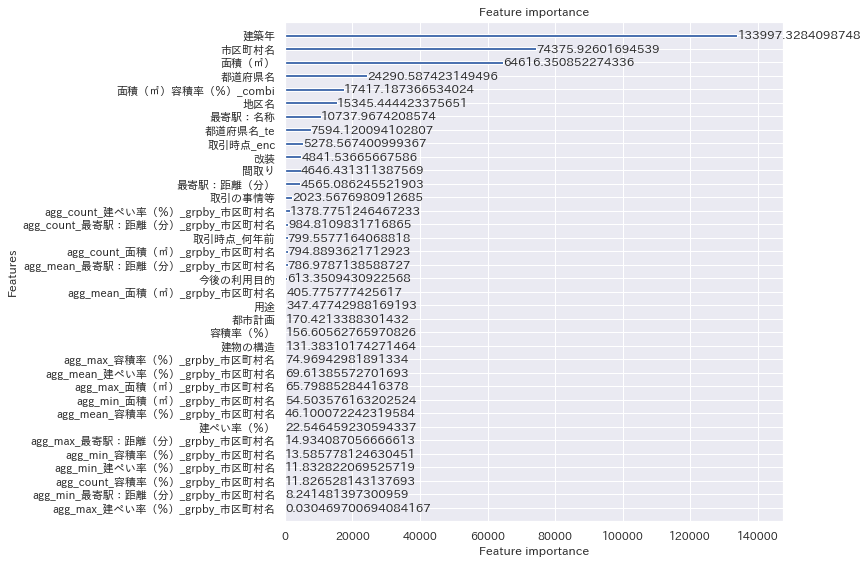

In [51]:
lgb.plot_importance(model, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.savefig(BASE_PATH + 'output/feature_importance.png')
plt.show()
plt.close()

## 予測実行

In [52]:
test_pred = model.predict(test_x, num_iteration=model.best_iteration)

In [53]:
test_df[TARGET] = test_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


##　提出用ファイルの作成

In [54]:
sub_df = pd.merge(sub_df[['ID']], test_df[['ID', TARGET]], on='ID')
sub_df.to_csv(BASE_PATH + 'output/test_submission.csv', index=False)